# 1.**Importing libraries and Dataset**

In [3]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Load dataset
df = pd.read_csv(r'D:\Future Interns\customer_support_tickets.csv')

In [7]:
# Data cleaning
df.drop_duplicates(inplace=True)
df['Ticket Description'].fillna('', inplace=True)

C:\Users\User\AppData\Local\Temp\ipykernel_19388\2286601528.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Ticket Description'].fillna('', inplace=True)


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8469 entries, 0 to 8468
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Ticket ID                     8469 non-null   int64  
 1   Customer Name                 8469 non-null   object 
 2   Customer Email                8469 non-null   object 
 3   Customer Age                  8469 non-null   int64  
 4   Customer Gender               8469 non-null   object 
 5   Product Purchased             8469 non-null   object 
 6   Date of Purchase              8469 non-null   object 
 7   Ticket Type                   8469 non-null   object 
 8   Ticket Subject                8469 non-null   object 
 9   Ticket Description            8469 non-null   object 
 10  Ticket Status                 8469 non-null   object 
 11  Resolution                    2769 non-null   object 
 12  Ticket Priority               8469 non-null   object 
 13  Tic

# 2.**Text Preprocessing**

In [11]:
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [14]:
def clean_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove non-alphanumeric characters and keep spaces
    text = ''.join(e for e in text if e.isalnum() or e.isspace())
    words = text.split()
    # Lemmatize and remove stopwords
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

In [16]:
df['cleaned_description'] = df['Ticket Description'].apply(clean_text)

# 3.**EDA**

In [48]:
df['Date of Purchase'] = pd.to_datetime(df['Date of Purchase'], errors='coerce')

In [50]:
# Set the 'Date of Purchase' column as the index for resampling
df.set_index('Date of Purchase', inplace=True)

In [52]:
issue_trends = df.resample('M').size()
print(issue_trends.head())

Date of Purchase
2020-01-31    377
2020-02-29    376
2020-03-31    324
2020-04-30    354
2020-05-31    322
Freq: ME, dtype: int64


C:\Users\User\AppData\Local\Temp\ipykernel_19388\4065931201.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  issue_trends = df.resample('M').size()


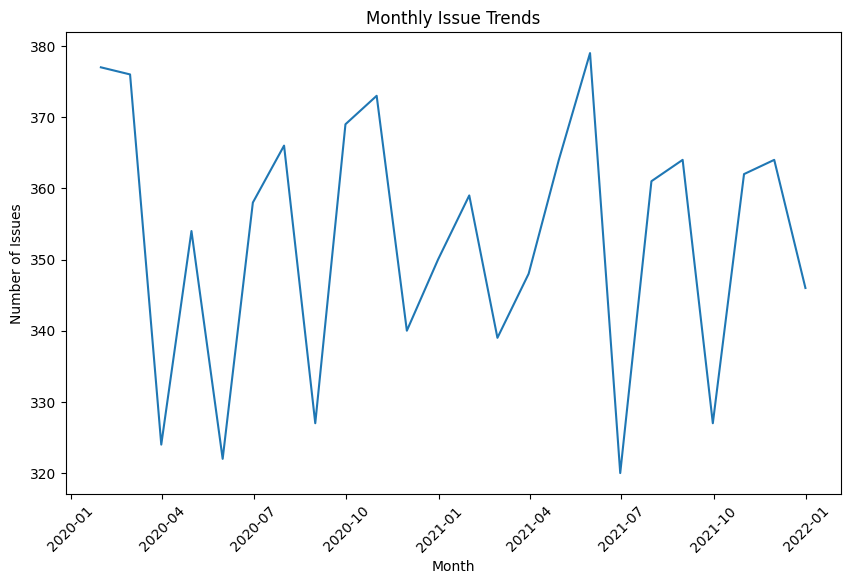

In [54]:
plt.figure(figsize=(10, 6))
sns.lineplot(x=issue_trends.index, y=issue_trends.values)
plt.title('Monthly Issue Trends')
plt.xlabel('Month')
plt.ylabel('Number of Issues')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

In [56]:
most_frequent_categories = df['category'].value_counts().head(5)
print("\nTop 5 Most Frequent Ticket Categories:")
print(most_frequent_categories)


Top 5 Most Frequent Ticket Categories:
category
3    4302
1    1385
4    1241
0    1069
2     472
Name: count, dtype: int64


In [62]:
avg_sentiment_by_category = df.groupby('category')['sentiment'].mean()

# Print average sentiment by category
print("\nAverage Sentiment by Category:")
print(avg_sentiment_by_category)


Average Sentiment by Category:
category
0    0.239955
1    0.351468
2    0.098906
3    0.420539
4    0.434216
Name: sentiment, dtype: float64


# 4.**Text categorization using TF-IDF + KMeans clustering**

In [18]:
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df['cleaned_description'])

In [21]:
# Clustering (KMeans)
kmeans = KMeans(n_clusters=5, random_state=42)
df['category'] = kmeans.fit_predict(X)

In [23]:
# After clustering, display the first few rows with their assigned category
print(df[['Ticket ID', 'category']].head())

   Ticket ID  category
0          1         1
1          2         3
2          3         4
3          4         3
4          5         3


In [25]:
print(df['category'].value_counts())

category
3    4302
1    1385
4    1241
0    1069
2     472
Name: count, dtype: int64


In [27]:
# Convert Time to Resolution to numeric
def convert_to_numeric(time_str):
    try:
        return float(time_str)
    except:
        return None 

In [29]:
print(df['Time to Resolution'].head())

0                    NaN
1                    NaN
2    2023-06-01 18:05:38
3    2023-06-01 01:57:40
4    2023-06-01 19:53:42
Name: Time to Resolution, dtype: object


# 5.**Sentiment Analysis**

In [40]:
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()
df['sentiment'] = df['cleaned_description'].apply(lambda x: sia.polarity_scores(x)['compound'])

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [42]:
print(df[['Ticket ID', 'sentiment']].head())

   Ticket ID  sentiment
0          1     0.7906
1          2     0.6597
2          3     0.1689
3          4     0.8885
4          5     0.4404


# 5.1.**Visualization of sentiment distribution**

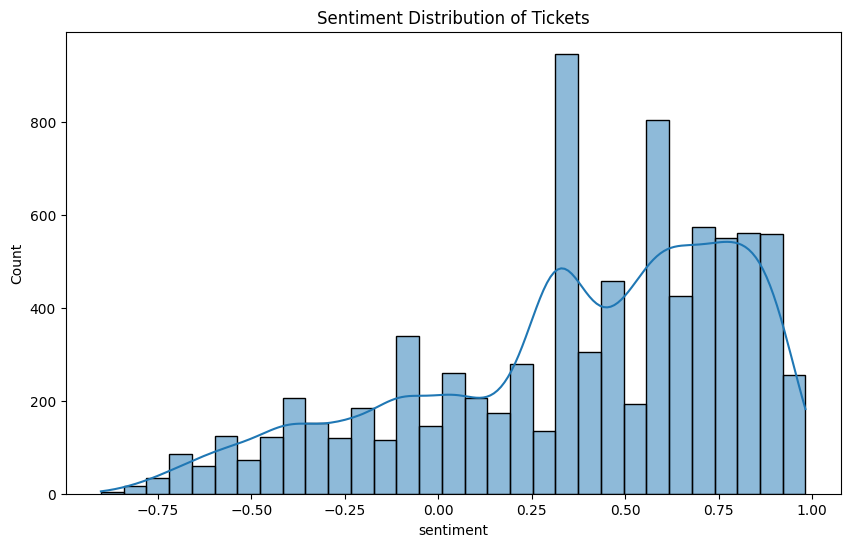

In [44]:
plt.figure(figsize=(10, 6))
sns.histplot(df['sentiment'], kde=True)
plt.title('Sentiment Distribution of Tickets')
plt.show()

# 6.**Summary Report Generation**

In [65]:
summary_report = {
    'Frequently Reported Problems': df['Ticket Subject'].value_counts().head(5),
    'Frequently Reported Categories': most_frequent_categories,
    'Average Resolution Time by Category': avg_resolution_time,
    'Average Sentiment by Category': avg_sentiment_by_category,
    'Monthly Issue Trends': issue_trends,
}

In [71]:
print("\nSummary Report on Customer Support Tickets\n")
print("Frequently Reported Problems:")
print(df['Ticket Subject'].value_counts().head(5))
print("\nFrequently Reported Categories:")
print(most_frequent_categories)
print("\nAverage Sentiment by Category:")
print(avg_sentiment_by_category)


Summary Report on Customer Support Tickets

Frequently Reported Problems:
Ticket Subject
Refund request           576
Software bug             574
Product compatibility    567
Delivery problem         561
Hardware issue           547
Name: count, dtype: int64

Frequently Reported Categories:
category
3    4302
1    1385
4    1241
0    1069
2     472
Name: count, dtype: int64

Average Sentiment by Category:
category
0    0.239955
1    0.351468
2    0.098906
3    0.420539
4    0.434216
Name: sentiment, dtype: float64


In [73]:
print("\nMonthly Issue Trends:")
print(issue_trends)


Monthly Issue Trends:
Date of Purchase
2020-01-31    377
2020-02-29    376
2020-03-31    324
2020-04-30    354
2020-05-31    322
2020-06-30    358
2020-07-31    366
2020-08-31    327
2020-09-30    369
2020-10-31    373
2020-11-30    340
2020-12-31    350
2021-01-31    359
2021-02-28    339
2021-03-31    348
2021-04-30    364
2021-05-31    379
2021-06-30    320
2021-07-31    361
2021-08-31    364
2021-09-30    327
2021-10-31    362
2021-11-30    364
2021-12-31    346
Freq: ME, dtype: int64


# 7.**Recommendations**

In [86]:
recommendations = []

In [88]:
# Recommendation 1: Categories with long resolution time
long_resolution_issues = avg_resolution_time[avg_resolution_time > avg_resolution_time.median()]
if not long_resolution_issues.empty:
    recommendations.append("Consider allocating more resources to categories with high resolution times, such as: " + ', '.join(long_resolution_issues.index.astype(str)))


In [90]:
# Recommendation 2: Categories with negative sentiment
negative_sentiment_categories = avg_sentiment_by_category[avg_sentiment_by_category < 0]
if not negative_sentiment_categories.empty:
    recommendations.append("Focus on improving customer experience in categories with negative sentiment, such as: " + ', '.join(negative_sentiment_categories.index.astype(str)))


In [94]:
# Recommendation 3: Increasing issue trends
increasing_trend = issue_trends[issue_trends.diff() > 0]
if not increasing_trend.empty:
    recommendations.append("There is an increasing trend in support tickets during these months: " + ', '.join(increasing_trend.index.strftime('%Y-%m').tolist()))



In [98]:
# Display the recommendations
print("\nRecommended Process Improvements:")
for recommendation in recommendations:
    print(f"- {recommendation}")


Recommended Process Improvements:
- There is an increasing trend in support tickets during these months: 2020-04, 2020-06, 2020-07, 2020-09, 2020-10, 2020-12, 2021-01, 2021-03, 2021-04, 2021-05, 2021-07, 2021-08, 2021-10, 2021-11
